In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os  # noqa
import sys  # noqa

proj_root = os.path.dirname(os.getcwd())
sys.path.append(proj_root)

OBJ_NAME = "mustard_bottle"
VIDEO_NAME = "mustard0"

VIS_CONF_THRESHOLD = 0.9


video_dir = os.path.join(proj_root, "data", "inputs", VIDEO_NAME)
tracker_result_video = os.path.join(video_dir)
obj_dir = os.path.join(proj_root, "data", "objects", OBJ_NAME)

In [3]:
import matplotlib.pyplot as plt
import torch
from posingpixels.datasets import YCBinEOATDataset, load_video_images
from posingpixels.utils.cotracker import visualize_results
from posingpixels.utils.evaluation import get_gt_tracks
from posingpixels.pnp import GradientPnP

import time

import tqdm
from posingpixels.pnp import OpenCVePnP
from posingpixels.query_refiner import QueryRefiner
from posingpixels.utils.cotracker import unscale_by_crop

from posingpixels.utils.evaluation import compute_add_metrics

from posingpixels.pointselector import SelectMostConfidentPoint
from posingpixels.utils.evaluation import compute_tapvid_metrics


import mediapy
from posingpixels.utils.geometry import (
    apply_pose_to_points_batch,
    render_points_in_2d_batch,
)
from posingpixels.visualization import overlay_bounding_box_on_video

import random
import numpy as np
from posingpixels.alignment import CanonicalPointSampler
from posingpixels.cotracker import CropCoPoseTracker
from posingpixels.pnp import OpenCVePnP
from posingpixels.cotracker import CoTrackerInput
from posingpixels.pointselector import SelectMostConfidentView
from posingpixels.utils.cotracker import get_ground_truths

torch.manual_seed(42)
random.seed(0)
np.random.seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

/home/joao/miniconda3/envs/gspose/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [4]:
from inference import create_reference_database_from_RGB_images
from posingpixels.datasets import ModelType
from posingpixels.utils.gs_pose import create_or_load_gaussian_splat_from_ycbineoat, load_model_net


dataset = YCBinEOATDataset(video_dir, obj_dir, model_type=ModelType.CAD)
model_net = load_model_net(os.path.join(proj_root, "checkpoints/model_weights.pth"))

ref_database = create_or_load_gaussian_splat_from_ycbineoat(dataset, model_net, device=device)

/home/joao/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/joao/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/joao/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Load database from  /home/joao/Documents/repositories/GSPose/data/objects/mustard_bottle/reference_database.pkl
load 3D-OGS model from  /home/joao/Documents/repositories/GSPose/data/objects/mustard_bottle/3DGO_model.ply


In [5]:
# Create an empty file poses.txt in the video directory
poses_file = os.path.join(video_dir, "poses.txt")
# Delete the file if it already exists
if os.path.exists(poses_file):
    os.remove(poses_file)
# Write the ground truth poses to the file
with open(poses_file, "w") as f:
    for pose in dataset.get_gt_poses():
        with open(poses_file, "a") as f:
            pose_str = " ".join([str(p) for p in pose.flatten()])
            f.write(pose_str + "\n")
            
# Create an empty file bounding_box.txt in the video directory
bounding_box_file = os.path.join(video_dir, "bounding_box.txt")
# Delete the file if it already exists
if os.path.exists(bounding_box_file):
    os.remove(bounding_box_file)
# Write the ground truth bounding boxes to the file
with open(bounding_box_file, "w") as f:
    bounding_box = dataset.bbox
    bbox_str = " ".join([str(p) for p in bounding_box.detach().cpu().numpy().flatten()])
    f.write(bbox_str + "\n")

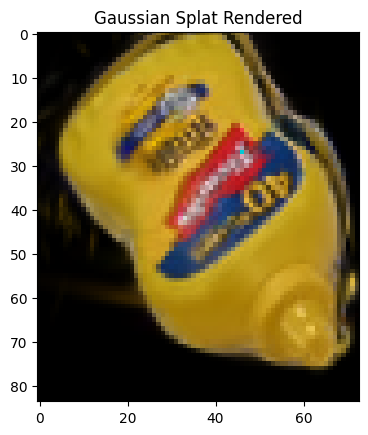

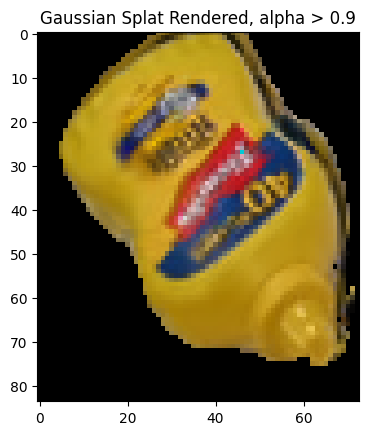

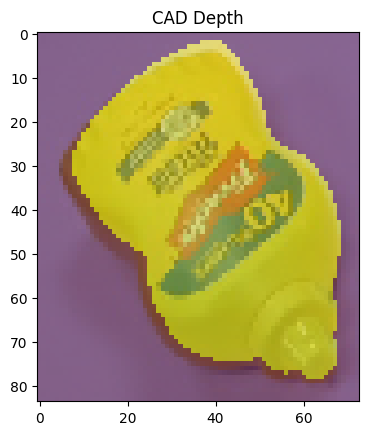

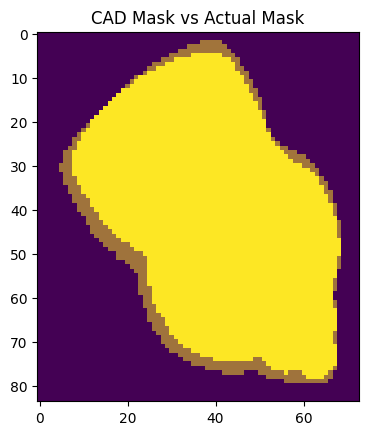

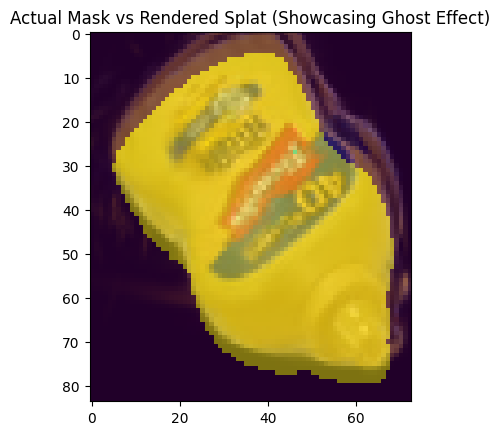

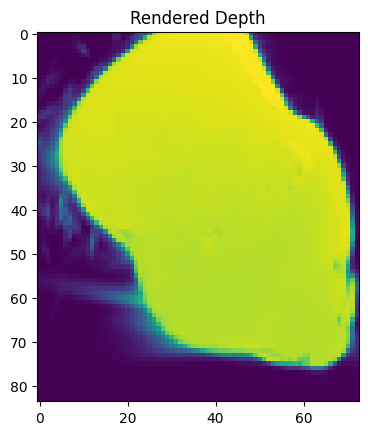

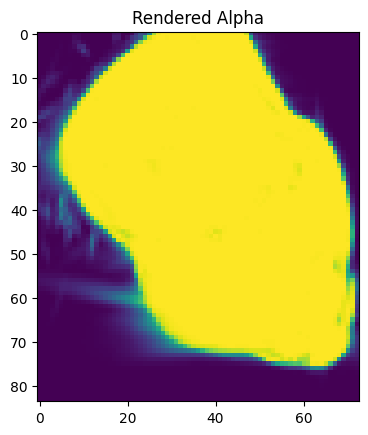

In [6]:
from posingpixels.utils.gs_pose import render_gaussian_model, render_gaussian_model_with_info
from posingpixels.visualization import get_gaussian_splat_pointcloud, plot_pointclouds

frame_idx = 0

gaussian_object = ref_database["obj_gaussians"]

object_pointcloud = get_gaussian_splat_pointcloud(gaussian_object)
plot_pointclouds({OBJ_NAME.capitalize(): object_pointcloud}, "Gaussian Object")

initial_pose = dataset.get_gt_pose(frame_idx)
initial_R, initial_T = initial_pose[:3, :3], initial_pose[:3, 3]

render = render_gaussian_model_with_info(
    gaussian_object, dataset.K, dataset.H, dataset.W, R=initial_R, T=initial_T
)

mask = dataset.get_mask(frame_idx) > 0.7
x1, y1, x2, y2 = np.min(np.where(mask)[1]) - 5, np.min(np.where(mask)[0]) - 5, np.max(np.where(mask)[1]) + 5, np.max(np.where(mask)[0]) + 5

image = render['image'][y1:y2, x1:x2]
alpha = render['alpha'][0, y1:y2, x1:x2].detach().cpu().numpy()
depth = render['depth'][0, y1:y2, x1:x2].detach().cpu().numpy()
cad_depth = dataset.get_cad_depth(frame_idx)[y1:y2, x1:x2]
mask = dataset.get_mask(frame_idx)[y1:y2, x1:x2] > 0.7
rgb = dataset.get_rgb(frame_idx)[y1:y2, x1:x2]

image_high_alpha = image.copy()
image_high_alpha[alpha < 0.9] = 0

plt.imshow(image)
plt.title("Gaussian Splat Rendered")
plt.show()

plt.imshow(image_high_alpha)
# plt.imshow(alpha > 0.99, alpha=0.5)
plt.title("Gaussian Splat Rendered, alpha > 0.9")
plt.show()

plt.imshow(cad_depth)
plt.imshow(rgb, alpha=0.5)
plt.title("CAD Depth")
plt.show()

plt.imshow(cad_depth > 0)
plt.imshow(mask, alpha=0.5)
plt.title("CAD Mask vs Actual Mask")
plt.show()


plt.imshow(image)
plt.imshow(mask, alpha=0.5)
plt.title("Actual Mask vs Rendered Splat (Showcasing Ghost Effect)")
plt.show()

# plt.imshow(alpha > 0.99)
# plt.show()
plt.imshow(depth)
plt.title("Rendered Depth")
plt.show()

plt.imshow(alpha)
plt.title("Rendered Alpha")
plt.show()

# # Overlap alpha with image 50% transparency
# plt.imshow(image)
# plt.imshow(alpha > 0.99, alpha=0.7)
# plt.show()

In [7]:
pnp_solver = OpenCVePnP(min_inliers=20, ransac_inliner_threshold=2.0)
# tracker = CoMeshTracker(
#     dataset,
#     None,
#     # support_grid=10,
#     offline=False,
#     # crop=False,
#     # visible_background=True,
#     # downcast=True,
#     # better_initialization=False,
#     # limit=100,
#     # interpolation_steps=80,
#     axis_rotation_steps=40,
#     final_interpolation_steps=40,
#     query_frames=[0, 10, 20, 30],
#     device=device,
# )

point_sampler = CanonicalPointSampler()
tracker = CropCoPoseTracker(
    canonical_point_sampler=point_sampler,
    # pnp_solver=pnp_solver,
    pose_interpolation_steps=1,
)

In [9]:
# dataset.reset_frame_range()
# with torch.no_grad():
#     pred_tracks, pred_visibility, pred_confidence, pred_tracks_original, tracker_input = (
#         tracker(dataset)
#     )
# Q = tracker_input.num_query_points
# N = len(tracker_input)
# # Pickle the results
# import pickle

# with open(os.path.join(video_dir, "tracker_results.pkl"), "wb") as f:
#     pickle.dump(
#         {
#             "pred_tracks": pred_tracks,
#             "pred_visibility": pred_visibility,
#             "pred_confidence": pred_confidence,
#             "pred_tracks_original": pred_tracks_original,
#             "N": N,
#             "Q": Q,
#             "bboxes": tracker_input.bboxes[tracker_input.prepend_length:],
#             "scaling": tracker_input.scaling[tracker_input.prepend_length:],
#             "video": load_video_images(tracker_input.video_dir)[:, tracker_input.prepend_length:],
#         },
#         f,
#     )
    
# Load the results
import pickle

with open(os.path.join(video_dir, "tracker_results.pkl"), "rb") as f:
    results = pickle.load(f)
    pred_tracks = results["pred_tracks"]
    pred_visibility = results["pred_visibility"]
    pred_confidence = results["pred_confidence"]
    pred_tracks_original = results["pred_tracks_original"]
    N = results["N"]
    Q = results["Q"]
    bboxes = results["bboxes"]
    scaling = results["scaling"]
    video = results["video"]
    

In [10]:
def choose_best(
    tracker_input: CoTrackerInput, pred_tracks, pred_visibility, pred_confidence, view=False
):
    true_indexes = torch.tensor(tracker_input.query_to_point_indexes, device=device)
    query_lengths = torch.tensor(tracker_input.query_lengths, device=device)

    if not view:
        point_selector = SelectMostConfidentPoint(
            tracker_input.num_canonical_points, true_indexes, query_lengths
        )
    else:
        point_selector = SelectMostConfidentView(
            tracker_input.num_canonical_points, true_indexes, query_lengths
        )

    best_coords, best_vis, best_conf, best_indices = point_selector.query_to_point(
        pred_tracks[0],
        pred_visibility[0],
        pred_confidence[0],
        # pred_visibility[0] * pred_confidence[0],
    )
    best_coords = best_coords.unsqueeze(0)
    best_vis = best_vis.unsqueeze(0)
    best_conf = best_conf.unsqueeze(0)

    best_coords_original = unscale_by_crop(
        best_coords[0],
        torch.tensor(tracker_input.bboxes).to(device),
        torch.tensor(tracker_input.scaling).to(device),
    ).unsqueeze(0)

    return best_coords, best_vis, best_conf, best_coords_original, best_indices


def estimate_poses(
    tracker_input: CoTrackerInput, best_coords_original, best_vis, best_conf
):
    N = len(tracker_input)
    K = tracker_input.dataset.K
    x = (
        torch.tensor(tracker_input.canonical_points, dtype=torch.float32)
        .to(device)
        .unsqueeze(0)
        .repeat(N, 1, 1)
    )
    y = best_coords_original.detach().clone().squeeze(0)[:N]

    weights = (best_vis * best_conf).float()[:N]
    weights[best_vis * best_conf < VIS_CONF_THRESHOLD] = 0
    weights = weights.squeeze(0)

    camKs = torch.tensor(K[np.newaxis, :], device=device).float()

    epnp_cv_solver = OpenCVePnP(
        X=x[0],
        K=camKs,
    )
    epnp_cv_R, epnp_cv_T, err = epnp_cv_solver(
        y, X=x, K=torch.tensor(K).to(device).float(), weights=weights
    )

    epnp_cv_poses = torch.eye(4).to(device).unsqueeze(0).repeat(N, 1, 1)
    epnp_cv_poses[:, :3, :3] = epnp_cv_R
    epnp_cv_poses[:, :3, 3] = epnp_cv_T
    return epnp_cv_poses, err

# def improve_poses(
#     x, y, K, poses, weights
# ) -> torch.Tensor:
#     # Initialize the optimizer to the current pose
    
#     # Try every pose against every frame, take the best (using reprojection error w/ Huber loss)
    


with torch.no_grad():
    (
        pred_tracks_batch,
        pred_confidence_batch,
        pred_visibility_batch,
        pred_poses_batch,
        pred_poses_err,
        best_indices_batch
    ) = [], [], [], [], [], []
    dataset.reset_frame_range()
    start_pose = dataset.get_gt_pose(0)
    step = 32
    overlap = 0
    tracks = vis = conf = track_input = best_coords = best_conf = best_vis = None
    for i in range(0, dataset.max_frames, step - overlap):
        dataset.start_frame = i
        dataset.end_frame = min(i + step, dataset.max_frames)
        rgb = dataset.get_rgb(0)
        # plt.imshow(rgb)
        # plt.show()
        print(f"Processing frames {dataset.start_frame} to {dataset.end_frame}")
        # TODO: Force pose to always be in view, and if it is too far gone, do not include it
        # start_pose[:3, 3] = np.array([0, 0, dataset._get_safe_distance()]) # TODO: Doesn't give right perspective, but ensures it's always in view
        rgb, depth, _ = dataset.render_mesh_at_pose(start_pose)
        # TODO: It's good to initialize every point (maybe with a confidence penalty for the ones in the dynamic template)
        # Initialzie dynamic ones from the ones in the best_coords for that point (same with conf and vis)
        if tracks is not None and overlap > 0:
            assert (
                vis is not None
                and conf is not None
                and track_input is not None
                and best_coords is not None
                and best_conf is not None
                and best_vis is not None
            )
            last_specific_length = track_input.query_lengths[-1] if len(track_input.query_lengths) > 4 else -tracks.shape[2]
            forced_coords = tracks[:, -overlap:, :-last_specific_length]
            forced_vis = vis[:, -overlap:, :-last_specific_length]
            forced_vis = torch.logit(forced_vis).clamp(-tracker.init_value, tracker.init_value)
            forced_conf = conf[:, -overlap:, :-last_specific_length]
            forced_conf = torch.logit(forced_conf).clamp(-tracker.init_value, tracker.init_value)
        else:
            forced_coords = forced_vis = forced_conf = None
        print(start_pose)
        canonical_poses = np.concatenate([tracker.get_canonical_poses(dataset.get_canonical_pose()), start_pose[np.newaxis]], axis=0)
        tracks, vis, conf, tracks_original, track_input = tracker(
            dataset,
            start_pose=start_pose,
            # query_poses=start_pose[np.newaxis],
            forced_coords=forced_coords,
            forced_vis=forced_vis,
            forced_conf=forced_conf,
        )

        Q = track_input.num_query_points
        N = len(track_input)

        best_coords, best_vis, best_conf, best_coords_original, best_indices = (
            choose_best(track_input, tracks, vis, conf, view=True)
        )
        best_indices_batch.append(best_indices[track_input.prepend_length :])
        

        poses, err = estimate_poses(track_input, best_coords_original, best_vis, best_conf)
        poses = poses[
            track_input.prepend_length :
        ]
        if err is not None:
            err = err[
                track_input.prepend_length :
            ]
        start_pose = poses[-1].detach().cpu().numpy()
        
        video = load_video_images(track_input.video_dir, limit=N)
        visualize_results(
            video,
            tracks,
            vis,
            conf,
            os.path.join(tracker_result_video, "dynamic"),
            # tracker_result_video + f"_{i}",
            num_of_main_queries=track_input.num_query_points,
            filename=f"dynamic_{i}",
        )
        
        visualize_results(
            video,
            best_coords,
            best_vis,
            best_conf,
            os.path.join(tracker_result_video, "dynamic"),
            # tracker_result_video + f"_{i}_best",
            num_of_main_queries=track_input.num_canonical_points,
            filename=f"dynamic_{i}_best",
        )
        
        best_coords, best_vis, best_conf, best_coords_original, best_indices = (
            choose_best(track_input, tracks, vis, conf, view=False)
        )


        print(tracks.shape, vis.shape, conf.shape)
        tracks = tracks[:, track_input.prepend_length :]
        vis = vis[:, track_input.prepend_length :]
        conf = conf[:, track_input.prepend_length :]
        print(tracks.shape, vis.shape, conf.shape)

        pred_tracks_batch.append(tracks.cpu().numpy())
        pred_visibility_batch.append(vis.cpu().numpy())
        pred_confidence_batch.append(conf.cpu().numpy())
        pred_poses_batch.append(poses.cpu().numpy())
        pred_poses_err.append(err)


Processing frames 0 to 32
[[ 0.62022826 -0.25150074  0.74355749 -0.44857676]
 [-0.76885377 -0.38178473  0.51219203  0.11785102]
 [ 0.15607195 -0.88858822 -0.43121622  0.80336017]
 [ 0.          0.          0.          1.        ]]


Preparing images for CoTracker: 100%|██████████| 52/52 [00:01<00:00, 45.62it/s]
Processing batches: 7it [00:03,  2.23it/s]                       


Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_0.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_0_best.mp4
torch.Size([1, 52, 487, 2]) torch.Size([1, 52, 487]) torch.Size([1, 52, 487])
torch.Size([1, 32, 487, 2]) torch.Size([1, 32, 487]) torch.Size([1, 32, 487])
Processing frames 32 to 64
[[ 0.6121792  -0.23220502  0.75585544 -0.45722613]
 [-0.7641313  -0.41952807  0.4899995   0.12042276]
 [ 0.20332222 -0.87754035 -0.4342615   0.81529766]
 [ 0.          0.          0.          1.        ]]


Preparing images for CoTracker: 100%|██████████| 52/52 [00:01<00:00, 47.54it/s]
Processing batches: 7it [00:01,  3.64it/s]                       


Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_32.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_32_best.mp4
torch.Size([1, 52, 487, 2]) torch.Size([1, 52, 487]) torch.Size([1, 52, 487])
torch.Size([1, 32, 487, 2]) torch.Size([1, 32, 487]) torch.Size([1, 32, 487])
Processing frames 64 to 96
[[ 0.6107682  -0.21558905  0.76189476 -0.45131394]
 [-0.75282025 -0.45632854  0.474369    0.11894348]
 [ 0.24540555 -0.86329925 -0.44101074  0.8018152 ]
 [ 0.          0.          0.          1.        ]]


Preparing images for CoTracker: 100%|██████████| 52/52 [00:01<00:00, 45.87it/s]
Processing batches: 7it [00:01,  3.56it/s]                       


Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_64.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_64_best.mp4
torch.Size([1, 52, 487, 2]) torch.Size([1, 52, 487]) torch.Size([1, 52, 487])
torch.Size([1, 32, 487, 2]) torch.Size([1, 32, 487]) torch.Size([1, 32, 487])
Processing frames 96 to 128
[[ 0.21135624 -0.00879258  0.97736955 -0.29908276]
 [-0.8064192  -0.5665939   0.16929103 -0.06785684]
 [ 0.5522831  -0.8239503  -0.12684365  0.712495  ]
 [ 0.          0.          0.          1.        ]]


Preparing images for CoTracker: 100%|██████████| 52/52 [00:01<00:00, 44.62it/s]
Processing batches: 7it [00:02,  3.31it/s]                       


Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_96.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_96_best.mp4
torch.Size([1, 52, 487, 2]) torch.Size([1, 52, 487]) torch.Size([1, 52, 487])
torch.Size([1, 32, 487, 2]) torch.Size([1, 32, 487]) torch.Size([1, 32, 487])
Processing frames 128 to 160
[[-5.72181463e-01  1.09552935e-01  8.12777042e-01  5.48106094e-04]
 [-6.93817377e-01 -5.93084633e-01 -4.08494890e-01 -9.37152505e-02]
 [ 4.37293738e-01 -7.97652066e-01  4.15361762e-01  5.90355217e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Preparing images for CoTracker: 100%|██████████| 52/52 [00:01<00:00, 43.25it/s]
Processing batches: 7it [00:02,  3.25it/s]                       


Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_128.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_128_best.mp4
torch.Size([1, 52, 487, 2]) torch.Size([1, 52, 487]) torch.Size([1, 52, 487])
torch.Size([1, 32, 487, 2]) torch.Size([1, 32, 487]) torch.Size([1, 32, 487])
Processing frames 160 to 192
[[-5.6983137e-01  9.8901428e-02  8.1578845e-01  2.6086223e-04]
 [-6.9512606e-01 -5.8748126e-01 -4.1432542e-01 -8.8318668e-02]
 [ 4.3828306e-01 -8.0317140e-01  4.0351421e-01  5.6610823e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


Preparing images for CoTracker: 100%|██████████| 52/52 [00:01<00:00, 43.01it/s]
Processing batches: 7it [00:02,  3.28it/s]                       


Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_160.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_160_best.mp4
torch.Size([1, 52, 487, 2]) torch.Size([1, 52, 487]) torch.Size([1, 52, 487])
torch.Size([1, 32, 487, 2]) torch.Size([1, 32, 487]) torch.Size([1, 32, 487])
Processing frames 192 to 224
[[-5.6509775e-01  9.4326414e-02  8.1961393e-01 -2.3682833e-04]
 [-6.9432706e-01 -5.9095782e-01 -4.1070524e-01 -8.7129779e-02]
 [ 4.4561693e-01 -8.0116874e-01  3.9944232e-01  5.6016368e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


Preparing images for CoTracker: 100%|██████████| 52/52 [00:01<00:00, 42.24it/s]
Processing batches: 7it [00:02,  3.32it/s]                       


Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_192.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_192_best.mp4
torch.Size([1, 52, 487, 2]) torch.Size([1, 52, 487]) torch.Size([1, 52, 487])
torch.Size([1, 32, 487, 2]) torch.Size([1, 32, 487]) torch.Size([1, 32, 487])
Processing frames 224 to 256
[[-5.5381477e-01  8.3966635e-02  8.2839531e-01 -1.5919576e-04]
 [-6.8553448e-01 -6.1065662e-01 -3.9641014e-01 -8.6544745e-02]
 [ 4.7257987e-01 -7.8743136e-01  3.9575267e-01  5.5872381e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


Preparing images for CoTracker: 100%|██████████| 52/52 [00:01<00:00, 42.70it/s]
Processing batches: 7it [00:02,  3.33it/s]                       


Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_224.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_224_best.mp4
torch.Size([1, 52, 487, 2]) torch.Size([1, 52, 487]) torch.Size([1, 52, 487])
torch.Size([1, 32, 487, 2]) torch.Size([1, 32, 487]) torch.Size([1, 32, 487])
Processing frames 256 to 288
[[-5.4504240e-01  6.8153113e-02  8.3563381e-01 -4.1392920e-04]
 [-6.9288230e-01 -5.9779793e-01 -4.0317711e-01 -8.5941352e-02]
 [ 4.7206238e-01 -7.9874450e-01  3.7304729e-01  5.5505276e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


Preparing images for CoTracker: 100%|██████████| 52/52 [00:01<00:00, 41.56it/s]
Processing batches: 7it [00:02,  3.16it/s]                       


Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_256.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_256_best.mp4
torch.Size([1, 52, 487, 2]) torch.Size([1, 52, 487]) torch.Size([1, 52, 487])
torch.Size([1, 32, 487, 2]) torch.Size([1, 32, 487]) torch.Size([1, 32, 487])
Processing frames 288 to 320
[[-5.3631610e-01  6.2380534e-02  8.4170884e-01 -2.8319543e-04]
 [-6.9692105e-01 -5.9526926e-01 -3.9994445e-01 -8.6275421e-02]
 [ 4.7609460e-01 -8.0110127e-01  3.6272678e-01  5.5615628e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


Preparing images for CoTracker: 100%|██████████| 52/52 [00:01<00:00, 42.74it/s]
Processing batches: 7it [00:02,  3.30it/s]                       


Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_288.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_288_best.mp4
torch.Size([1, 52, 487, 2]) torch.Size([1, 52, 487]) torch.Size([1, 52, 487])
torch.Size([1, 32, 487, 2]) torch.Size([1, 32, 487]) torch.Size([1, 32, 487])
Processing frames 320 to 352
[[-5.4783762e-01  7.3366195e-02  8.3336151e-01 -3.8308027e-04]
 [-6.9565290e-01 -5.9327644e-01 -4.0508038e-01 -8.5889839e-02]
 [ 4.6469453e-01 -8.0164862e-01  3.7605655e-01  5.5317146e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


Preparing images for CoTracker: 100%|██████████| 52/52 [00:01<00:00, 41.88it/s]
Processing batches: 7it [00:02,  3.31it/s]                       


Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_320.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_320_best.mp4
torch.Size([1, 52, 487, 2]) torch.Size([1, 52, 487]) torch.Size([1, 52, 487])
torch.Size([1, 32, 487, 2]) torch.Size([1, 32, 487]) torch.Size([1, 32, 487])
Processing frames 352 to 384
[[-0.5571956   0.18721461  0.80900174 -0.00287714]
 [-0.76655823 -0.490533   -0.41444647 -0.10130389]
 [ 0.3192516  -0.85107464  0.4168337   0.6003541 ]
 [ 0.          0.          0.          1.        ]]


Preparing images for CoTracker: 100%|██████████| 52/52 [00:01<00:00, 37.82it/s]
Processing batches: 7it [00:02,  3.36it/s]                       


Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_352.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_352_best.mp4
torch.Size([1, 52, 487, 2]) torch.Size([1, 52, 487]) torch.Size([1, 52, 487])
torch.Size([1, 32, 487, 2]) torch.Size([1, 32, 487]) torch.Size([1, 32, 487])
Processing frames 384 to 416
[[-0.5659048   0.19397186  0.80132806 -0.00388039]
 [-0.7659607  -0.48330146 -0.4239386  -0.09603768]
 [ 0.30505088 -0.8536947   0.42207742  0.5787803 ]
 [ 0.          0.          0.          1.        ]]


Preparing images for CoTracker: 100%|██████████| 52/52 [00:01<00:00, 43.75it/s]
Processing batches: 7it [00:02,  3.36it/s]                       


Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_384.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_384_best.mp4
torch.Size([1, 52, 487, 2]) torch.Size([1, 52, 487]) torch.Size([1, 52, 487])
torch.Size([1, 32, 487, 2]) torch.Size([1, 32, 487]) torch.Size([1, 32, 487])
Processing frames 416 to 448
[[-0.44594917  0.16895066  0.8789681  -0.00361434]
 [-0.8004365  -0.51473314 -0.3071664  -0.10409198]
 [ 0.40053806 -0.8405388   0.3647791   0.59234715]
 [ 0.          0.          0.          1.        ]]


Preparing images for CoTracker: 100%|██████████| 52/52 [00:01<00:00, 42.68it/s]
Processing batches: 7it [00:02,  3.34it/s]                       


Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_416.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_416_best.mp4
torch.Size([1, 52, 487, 2]) torch.Size([1, 52, 487]) torch.Size([1, 52, 487])
torch.Size([1, 32, 487, 2]) torch.Size([1, 32, 487]) torch.Size([1, 32, 487])
Processing frames 448 to 480
[[-0.43553552  0.19221346  0.8794105  -0.00499775]
 [-0.8164707  -0.49573502 -0.29601082 -0.1007319 ]
 [ 0.37905732 -0.8469361   0.37284687  0.5714418 ]
 [ 0.          0.          0.          1.        ]]


Preparing images for CoTracker: 100%|██████████| 52/52 [00:01<00:00, 44.17it/s]
Processing batches: 7it [00:02,  3.32it/s]                       


Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_448.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_448_best.mp4
torch.Size([1, 52, 487, 2]) torch.Size([1, 52, 487]) torch.Size([1, 52, 487])
torch.Size([1, 32, 487, 2]) torch.Size([1, 32, 487]) torch.Size([1, 32, 487])
Processing frames 480 to 512
[[-0.4181146   0.16933906  0.89247096 -0.0052219 ]
 [-0.81581646 -0.5021094  -0.2869315  -0.101812  ]
 [ 0.39952934 -0.84806275  0.34808886  0.5749604 ]
 [ 0.          0.          0.          1.        ]]


Preparing images for CoTracker: 100%|██████████| 52/52 [00:01<00:00, 40.89it/s]
Processing batches: 7it [00:02,  3.36it/s]                       


Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_480.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_480_best.mp4
torch.Size([1, 52, 487, 2]) torch.Size([1, 52, 487]) torch.Size([1, 52, 487])
torch.Size([1, 32, 487, 2]) torch.Size([1, 32, 487]) torch.Size([1, 32, 487])
Processing frames 512 to 544
[[-0.37543124  0.20951298  0.90285975 -0.01798776]
 [-0.75840807 -0.6294061  -0.16930793 -0.10948389]
 [ 0.5327932  -0.7482996   0.39519504  0.61949706]
 [ 0.          0.          0.          1.        ]]


Preparing images for CoTracker: 100%|██████████| 52/52 [00:01<00:00, 42.97it/s]
Processing batches: 7it [00:02,  3.37it/s]                       


Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_512.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_512_best.mp4
torch.Size([1, 52, 487, 2]) torch.Size([1, 52, 487]) torch.Size([1, 52, 487])
torch.Size([1, 32, 487, 2]) torch.Size([1, 32, 487]) torch.Size([1, 32, 487])
Processing frames 544 to 576
[[-0.3676197   0.12489632  0.9215512  -0.03434053]
 [-0.7176392  -0.66835415 -0.1956954  -0.10623648]
 [ 0.5914809  -0.7332828   0.33533064  0.6202957 ]
 [ 0.          0.          0.          1.        ]]


Preparing images for CoTracker: 100%|██████████| 52/52 [00:01<00:00, 37.22it/s]
Processing batches: 7it [00:02,  3.28it/s]                       


Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_544.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_544_best.mp4
torch.Size([1, 52, 487, 2]) torch.Size([1, 52, 487]) torch.Size([1, 52, 487])
torch.Size([1, 32, 487, 2]) torch.Size([1, 32, 487]) torch.Size([1, 32, 487])
Processing frames 576 to 608
[[-2.0547488e-01 -6.4726979e-01  7.3404491e-01 -4.0700286e+12]
 [ 6.3841259e-01  4.7983718e-01  6.0181862e-01 -1.4839973e+13]
 [-7.4176103e-01  5.9228212e-01  3.1463072e-01  3.8239776e+13]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


Preparing images for CoTracker: 100%|██████████| 52/52 [00:00<00:00, 55.53it/s] 
Processing batches: 7it [00:02,  3.48it/s]                       


Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_576.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_576_best.mp4
torch.Size([1, 52, 487, 2]) torch.Size([1, 52, 487]) torch.Size([1, 52, 487])
torch.Size([1, 32, 487, 2]) torch.Size([1, 32, 487]) torch.Size([1, 32, 487])
Processing frames 608 to 640
[[-0.40049556  0.88820845 -0.2251424  -0.10748746]
 [-0.39248088 -0.38831386 -0.8337692   0.08719912]
 [-0.8279868  -0.24555677  0.5041228   0.63134736]
 [ 0.          0.          0.          1.        ]]


Preparing images for CoTracker: 100%|██████████| 52/52 [00:01<00:00, 46.68it/s]
Processing batches: 7it [00:02,  3.46it/s]                       


Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_608.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_608_best.mp4
torch.Size([1, 52, 487, 2]) torch.Size([1, 52, 487]) torch.Size([1, 52, 487])
torch.Size([1, 32, 487, 2]) torch.Size([1, 32, 487]) torch.Size([1, 32, 487])
Processing frames 640 to 672
[[-9.4388658e-01  3.3026958e-01  4.1865936e-04 -8.2504362e-02]
 [ 1.5271883e-01  4.3758264e-01 -8.8611424e-01  1.1971191e-01]
 [-2.9283977e-01 -8.3632737e-01 -4.6346676e-01  6.2947512e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


Preparing images for CoTracker: 100%|██████████| 52/52 [00:01<00:00, 45.21it/s]
Processing batches: 7it [00:02,  3.49it/s]                       


Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_640.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_640_best.mp4
torch.Size([1, 52, 487, 2]) torch.Size([1, 52, 487]) torch.Size([1, 52, 487])
torch.Size([1, 32, 487, 2]) torch.Size([1, 32, 487]) torch.Size([1, 32, 487])
Processing frames 672 to 704
[[-0.9338885   0.35373148 -0.05221463 -0.07969739]
 [ 0.22298251  0.46198863 -0.85839695  0.11833822]
 [-0.27951947 -0.81328994 -0.5103218   0.62635875]
 [ 0.          0.          0.          1.        ]]


Preparing images for CoTracker: 100%|██████████| 52/52 [00:01<00:00, 46.19it/s]
Processing batches: 7it [00:02,  3.48it/s]                       


Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_672.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_672_best.mp4
torch.Size([1, 52, 487, 2]) torch.Size([1, 52, 487]) torch.Size([1, 52, 487])
torch.Size([1, 32, 487, 2]) torch.Size([1, 32, 487]) torch.Size([1, 32, 487])
Processing frames 704 to 736
[[-0.89987594  0.43076947 -0.068271   -0.06485214]
 [ 0.31891018  0.5430981  -0.77675015  0.0978927 ]
 [-0.2975224  -0.72075105 -0.6260977   0.6167272 ]
 [ 0.          0.          0.          1.        ]]


Preparing images for CoTracker: 100%|██████████| 52/52 [00:01<00:00, 32.28it/s]
Processing batches: 7it [00:02,  3.25it/s]                       


Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_704.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_704_best.mp4
torch.Size([1, 52, 487, 2]) torch.Size([1, 52, 487]) torch.Size([1, 52, 487])
torch.Size([1, 32, 487, 2]) torch.Size([1, 32, 487]) torch.Size([1, 32, 487])
Processing frames 736 to 737
[[-0.89365643  0.44319493 -0.07040164 -0.06283945]
 [ 0.33299974  0.5497686  -0.76607156  0.09597731]
 [-0.30081442 -0.7080485  -0.63888806  0.60569465]
 [ 0.          0.          0.          1.        ]]


Preparing images for CoTracker: 100%|██████████| 21/21 [00:00<00:00, 51.95it/s]
Processing batches: 3it [00:00,  4.32it/s]               


Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_736.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/dynamic/dynamic_736_best.mp4
torch.Size([1, 21, 487, 2]) torch.Size([1, 21, 487]) torch.Size([1, 21, 487])
torch.Size([1, 1, 487, 2]) torch.Size([1, 1, 487]) torch.Size([1, 1, 487])


In [11]:
# Pickle the results
import pickle

with open(tracker_result_video + ".pkl", "wb") as f:
    pickle.dump(
        (
            pred_tracks_batch,
            pred_visibility_batch,
            pred_confidence_batch,
            pred_poses_batch,
            pred_poses_err,
            best_indices_batch,
            track_input.canonical_points,
            step,
            overlap
        ),
        f,
    )

# Load the results

with open(tracker_result_video + ".pkl", "rb") as f:
    (
        pred_tracks_batch,
        pred_visibility_batch,
        pred_confidence_batch,
        pred_poses_batch,
        pred_poses_err,
        best_indices_batch,
        canonical_points,
        step,
        overlap
    ) = pickle.load(f)

In [13]:
dataset.reset_frame_range()
N = len(dataset)
video = load_video_images(tracker_input.video_dir)[:, -N:]
# init_video = load_video_images(tracker_input.prepend_dir, limit=N, file_type="jpg")
video_original = load_video_images(dataset.video_rgb_dir)[:, -N:]
# full_video = torch.cat([init_video, video_original], dim=1)[:, :N]

NameError: name 'tracker_input' is not defined

In [14]:
print(pred_poses_batch)
print(len(pred_poses_batch))
print(pred_poses_batch[0].shape)
pred_poses = []
for i, pose_batch in enumerate(pred_poses_batch):
    pred_poses.append(torch.tensor(pose_batch[int(i > 0) * overlap:]).float().to(device))
epnp_slide_poses = torch.cat(pred_poses, dim=0).detach().cpu().numpy()
print(epnp_slide_poses.shape)
K = dataset.K
camKs = torch.tensor(K[np.newaxis, :], device=device).float()
gt_poses = torch.tensor(dataset.get_gt_poses()).float().to(device)
print(gt_poses.shape)

video_permuted = video_original[0].permute(0, 2, 3, 1)
bbox_video = overlay_bounding_box_on_video(
    video_permuted.detach().cpu().numpy(),
    dataset.bbox.float(),
    camKs.repeat(len(dataset), 1, 1).cpu(),
    gt_poses.detach().cpu().numpy(),
)
bbox_video = overlay_bounding_box_on_video(
    bbox_video,
    dataset.bbox.float(),
    camKs.repeat(len(dataset), 1, 1).cpu(),
    epnp_slide_poses,
    color=(255, 0, 0),
)
mediapy.show_video(bbox_video, fps=15)

[array([[[ 0.61419785, -0.23349817,  0.75381666, -0.46448934],
        [-0.76716286, -0.4005905 ,  0.50098735,  0.12165722],
        [ 0.18499218, -0.8860056 , -0.42517295,  0.8278022 ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],

       [[ 0.6134909 , -0.23352478,  0.7543839 , -0.46026742],
        [-0.76519996, -0.41189966,  0.49478045,  0.12100855],
        [ 0.19518699, -0.88079786, -0.43138984,  0.82095754],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],

       [[ 0.6134909 , -0.23352478,  0.7543839 , -0.46026742],
        [-0.76519996, -0.41189966,  0.49478045,  0.12100855],
        [ 0.19518699, -0.88079786, -0.43138984,  0.82095754],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],

       [[ 0.61316586, -0.23190643,  0.75514704, -0.45697078],
        [-0.7625676 , -0.42329213,  0.48919776,  0.12025538],
        [ 0.20619969, -0.87581   , -0.4363926 ,  0.814692  ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [15]:
N = len(dataset)
K = dataset.K
x = (
    torch.tensor(canonical_points, dtype=torch.float32)
    .to(device)
    .unsqueeze(0)
    .repeat(N, 1, 1)
)
num_canonical_points = x.shape[1]

best_tracks_slide = torch.zeros(1, N, num_canonical_points, 2).to(device)
best_vis_slide = torch.zeros(1, N, num_canonical_points).to(device)
best_conf_slide = torch.zeros(1, N, num_canonical_points).to(device)
for i, coords, vis, conf, indices in zip(range(0, len(pred_tracks_batch)), pred_tracks_batch, pred_visibility_batch, pred_confidence_batch, best_indices_batch):
    coords = torch.tensor(coords).float().to(device)
    vis = torch.tensor(vis).float().to(device)
    conf = torch.tensor(conf).float().to(device)
    indices = torch.tensor(indices).int().to(device)
    valid_indices = indices[indices >= 0]
    invalid_indices_frames, invalid_indices_idx = torch.where(indices < 0)
    left = i * (step - overlap)
    right = min(left + step, dataset.max_frames)
    frames_window = torch.arange(left, right, device=device).unsqueeze(-1)
    if i > 0:
        right_overlap = min(left + overlap, dataset.max_frames)
        best_tracks_slide_overlap = best_tracks_slide[:, left:right_overlap]
        best_vis_slide_overlap = best_vis_slide[:, left:right_overlap]
        best_conf_slide_overlap = best_conf_slide[:, left:right_overlap]
    best_tracks_slide[:, frames_window[:, 0]] = coords[:, frames_window - left, indices]
    best_vis_slide[:, frames_window[:, 0]] = vis[:, frames_window - left, indices]
    best_conf_slide[:, frames_window[:, 0]] = conf[:, frames_window - left, indices]
    best_conf_slide[:, invalid_indices_frames + left, invalid_indices_idx] = 0
    best_vis_slide[:, invalid_indices_frames + left, invalid_indices_idx] = 0
    if i > 0:
        best_tracks_slide[:, left:right_overlap] = best_tracks_slide_overlap
        best_vis_slide[:, left:right_overlap] = best_vis_slide_overlap
        best_conf_slide[:, left:right_overlap] = best_conf_slide_overlap
        
    

visualize_results(
    video,
    best_tracks_slide,
    best_vis_slide,
    best_conf_slide,
    tracker_result_video + "_slide",
    num_of_main_queries=num_canonical_points,
)
# print(num_canonical_points, tracker_input.num_canonical_points)


y_slide = unscale_by_crop(
        best_tracks_slide[0],
        torch.tensor(bboxes).to(device),
        torch.tensor(scaling).to(device),
    )

# y = best_tracks_slide.detach().clone().squeeze(0)
init_poses = torch.tensor(epnp_slide_poses, device=device).float()[:N]

weights_slide = (best_vis_slide * best_conf_slide).float()
weights_slide[best_vis_slide * best_conf_slide < VIS_CONF_THRESHOLD] = 0
weights_slide = weights_slide.squeeze(0)
   
print(x.shape, camKs.shape, init_poses.shape, y_slide.shape, weights_slide.shape)
gradient_pnp = GradientPnP(
    max_lr=0.02,
    temporal_consistency_weight=1,
    X=x[0],
    K=camKs,
)

rotations, translations, all_results = gradient_pnp(
    y_slide,
    weights=weights_slide,
    R=init_poses[:, :3, :3],
    T=init_poses[:, :3, 3],
)

gradient_poses_slide = torch.eye(4).to(device).unsqueeze(0).repeat(N, 1, 1)
gradient_poses_slide[:, :3, :3] = rotations
gradient_poses_slide[:, :3, 3] = translations

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
from posingpixels.pointselector import SelectMostConfidentView


true_indexes = torch.tensor(tracker_input.query_to_point_indexes, device=device)
query_lengths = torch.tensor(tracker_input.query_lengths, device=device)

# tensor_query_to_point = torch.tensor(tracker.query_to_point, device=device)
# true_indexes = torch.nonzero(tensor_query_to_point)
# query_lengths = torch.tensor(tracker.queries_sizes, device=device)

# point_selector = SelectMostConfidentPoint(
#     tracker_input.num_canonical_points, true_indexes, query_lengths
# )
point_selector = SelectMostConfidentView(
    tracker_input.num_canonical_points, true_indexes, query_lengths
)

best_coords, best_vis, best_conf, best_indices = point_selector.query_to_point(
    pred_tracks[0],
    pred_visibility[0],
    pred_confidence[0],
    # pred_visibility[0] * pred_confidence[0],
)
best_coords = best_coords.unsqueeze(0)
best_vis = best_vis.unsqueeze(0)
best_conf = best_conf.unsqueeze(0)

best_coords_original = unscale_by_crop(
    best_coords[0],
    torch.tensor(tracker_input.bboxes).to(device),
    torch.tensor(tracker_input.scaling).to(device),
).unsqueeze(0)

In [ ]:
visualize_results(
    video,
    pred_tracks[:, tracker_input.prepend_length :],
    pred_visibility[:, tracker_input.prepend_length :],
    pred_confidence[:, tracker_input.prepend_length :],
    tracker_result_video,
    num_of_main_queries=Q,
)

visualize_results(
    video,
    best_coords[:, tracker_input.prepend_length :],
    best_vis[:, tracker_input.prepend_length :],
    best_conf[:, tracker_input.prepend_length :],
    tracker_result_video,
    filename="selected_video",
)

gt_tracks, gt_visibility = get_gt_tracks(tracker_input)
visualize_results(
    video,
    torch.tensor(gt_tracks).to(device).unsqueeze(0).float()[:, tracker_input.prepend_length :],
    torch.tensor(gt_visibility).to(device).unsqueeze(0).float()[:, tracker_input.prepend_length :],
    torch.ones_like(torch.tensor(gt_visibility).to(device)).unsqueeze(0).float()[:, tracker_input.prepend_length :],
    tracker_result_video,
    num_of_main_queries=Q,
    filename="gt_video",
    threshold=VIS_CONF_THRESHOLD,
)
# pred_tracks_original = unscale_by_crop(
#     pred_tracks[0],
#     torch.tensor(tracker_input.bboxes).to(device),
#     torch.tensor(tracker_input.scaling).to(device),
# ).unsqueeze(0)

# full_video = torch.cat([init_video, video_original], dim=1)[:, : N]
# visualize_results(
#     full_video,
#     pred_tracks_original,
#     pred_visibility,
#     pred_confidence,
#     tracker_result_video,
#     num_of_main_queries=Q,
#     filename="original",
#     threshold=VIS_CONF_THRESHOLD,
# )

# gt_tracks_original, gt_visibility_original = get_gt_tracks(tracker_input, crop=False)
# visualize_results(
#     full_video,
#     torch.tensor(gt_tracks_original).to(device).unsqueeze(0).float(),
#     torch.tensor(gt_visibility_original).to(device).unsqueeze(0).float(),
#     torch.ones_like(torch.tensor(gt_visibility_original).to(device))
#     .unsqueeze(0)
#     .float(),
#     tracker_result_video,
#     num_of_main_queries=Q,
#     filename="gt_original",
#     threshold=VIS_CONF_THRESHOLD,
# )

In [ ]:
query_points = tracker_input.input_query[
    np.newaxis, : tracker_input.num_canonical_points
]
print(query_points.shape)
gt_occluded = (gt_visibility.T < 0.5)[np.newaxis, :]
print(gt_occluded.shape)
gt_tracks_ = np.transpose(gt_tracks[np.newaxis, :], (0, 2, 1, 3))
print(gt_tracks_.shape)
pred_visibility_ = best_vis.permute(0, 2, 1).cpu().numpy()
pred_occluded = pred_visibility_ < 0.5
print(pred_occluded.shape)
pred_tracks_ = best_coords.permute(0, 2, 1, 3).cpu().numpy()
print(pred_tracks_.shape)
pred_confidence_ = best_conf.cpu().permute(0, 2, 1).numpy()
print(pred_confidence_.shape)

# We are only interested in evaluating points where confidence * visibility > 0.6 (B x N x T)
threshold = VIS_CONF_THRESHOLD
evaluation_points = pred_confidence_ * pred_visibility_ > threshold
# evaluation_points = np.ones_like(pred_confidence_, dtype=bool)

metrics = compute_tapvid_metrics(
    query_points=query_points,
    gt_occluded=gt_occluded,
    gt_tracks=gt_tracks_,
    pred_occluded=pred_occluded,
    pred_tracks=pred_tracks_,
    query_mode="first",
    evaluation_points=evaluation_points,
)
# Print the following metrics
print("occlusion_accuracy", metrics["occlusion_accuracy"])
print("average_jaccard", metrics["average_jaccard"])
print("average_pts_within_thresh", metrics["average_pts_within_thresh"])
print("pts_within_1", metrics["pts_within_1"])
print("jaccard_1", metrics["jaccard_1"])
print("pts_within_2", metrics["pts_within_2"])
print("jaccard_2", metrics["jaccard_2"])
print("pts_within_4", metrics["pts_within_4"])
print("jaccard_4", metrics["jaccard_4"])
print("pts_within_8", metrics["pts_within_8"])
print("jaccard_8", metrics["jaccard_8"])
print("pts_within_16", metrics["pts_within_16"])
print("jaccard_16", metrics["jaccard_16"])
print(metrics.keys())

In [ ]:
# How many points are being evaluated per time step?
evaluation_points.shape
plt.plot(evaluation_points.sum(axis=(0, 1)))
plt.title(
    f"Number of points considered per time step with visibility * confidence > {threshold}"
)

In [ ]:
metric_name = "per_point_pts_within_8"
values = metrics[metric_name][0]
# If we're doing a time metric, plot a line plot
# If we're doing a per point metric, plot distribution of values
plt.plot(values) if "time" in metric_name else plt.hist(values, bins=20)
# Plot vertical line on self.interpolation_steps
plt.axvline(
    tracker_input.prepend_length, color="r", linestyle="--"
) if "time" in metric_name else None
plt.title(f"{metric_name} (threshold={threshold})")
plt.xlabel("Frame" if "time" in metric_name else "Point")
plt.ylabel("Value")

In [ ]:
# ==========
# Input
# ==========
tracker_input.dataset.reset_frame_range()

K = tracker_input.dataset.K
x = (
    torch.tensor(tracker_input.canonical_points, dtype=torch.float32)
    .to(device)
    .unsqueeze(0)
    .repeat(N, 1, 1)
)
gt_poses = torch.tensor(tracker_input.gt_poses[tracker_input.prepend_length: tracker_input.prepend_length + N]).float().to(device)
gt_posed_x = apply_pose_to_points_batch(x, gt_poses[:, :3, :3], gt_poses[:, :3, 3])
y_gt = render_points_in_2d_batch(gt_posed_x, torch.tensor(K[:3, :3]).float().to(device))

y = best_coords_original.detach().clone().squeeze(0)[tracker_input.prepend_length: tracker_input.prepend_length + N]


weights = (best_vis * best_conf).float()
weights[best_vis * best_conf < VIS_CONF_THRESHOLD] = 0
weights = weights.squeeze(0)[tracker_input.prepend_length: tracker_input.prepend_length + N]

camKs = torch.tensor(K[np.newaxis, :], device=device).float()

# ==========
# ePnP
# ==========
# epnp_solver = RANSACePnP(num_iterations=100)
# epnp_solver = ePnP()
# epnp_R, epnp_T, _ = epnp_solver(
#     y,
#     X=x,
#     K=torch.tensor(K).to(device).float(),  # weights=weights
# )
# epnp_poses = torch.eye(4).to(device).unsqueeze(0).repeat(N, 1, 1)
# epnp_poses[:, :3, :3] = epnp_R
# epnp_poses[:, :3, 3] = epnp_T
# Start time
start_time = time.time()
epnp_cv_solver = OpenCVePnP(
    X=x[0],
    K=camKs,
    ransac_iterations=5000,
    ransac_inliner_threshold=2.0,
)
epnp_cv_R, epnp_cv_T, _ = epnp_cv_solver(
    y,
    # X=x,
    K=torch.tensor(K).to(device).float(), weights=weights,
)
epnp_cv_poses = torch.eye(4).to(device).unsqueeze(0).repeat(N, 1, 1)
epnp_cv_poses[:, :3, :3] = epnp_cv_R
epnp_cv_poses[:, :3, 3] = epnp_cv_T
# End time
end_time = time.time()
print(f"Time to run OpenCV ePnP: {end_time - start_time}")

# ==========
# Our Model Complete
# ==========
# query_refiner = QueryRefiner(
#     point_selector,
#     epnp_cv_solver,
#     torch.tensor(tracker_input.bboxes, device=device),
#     torch.tensor(tracker_input.scaling, device=device),
#     gt_poses[: tracker_input.prepend_length, :3, :3],
#     gt_poses[: tracker_input.prepend_length, :3, 3],
#     threshold=0.9,
#     pad_inputs=False,
# )
# coordinates = pred_tracks[0, :N].clone()
# visibility = pred_visibility[0, :N].clone()
# confidence = pred_confidence[0, :N].clone()
# optimization_results_query_refiner = []
# for i in tqdm.tqdm(range(N // query_refiner.step)):
#     if query_refiner.current >= N:
#         break
#     left = i * query_refiner.step
#     right = min((i + 1) * query_refiner.step + query_refiner.step, N)
#     (
#         coordinates[left:right],
#         visibility[left:right],
#         confidence[left:right],
#         opt_results,
#     ) = query_refiner(
#         coordinates[left:right], visibility[left:right], confidence[left:right]
#     )
#     optimization_results_query_refiner.append(opt_results)
# query_refiner_poses = torch.eye(4).to(device).unsqueeze(0).repeat(N, 1, 1)
# query_refiner_poses[:, :3, :3] = query_refiner.R
# query_refiner_poses[:, :3, 3] = query_refiner.T

# ==========
# Our model
# ==========

gradient_pnp = GradientPnP(
    max_lr=0.02,
    temporal_consistency_weight=1,
    X=x[0],
    K=camKs,
    # R=gt_poses[0, :3, :3],
    # T=gt_poses[0, :3, 3],
)

rotations, translations, all_results = gradient_pnp(
    y,
    weights=weights,
    # R=gt_poses[0, :3, :3],
    # T=gt_poses[0, :3, 3],
    # R=torch.eye(3).to(device),
    # T=torch.zeros(3).to(device),
    # R=query_refiner.R.clone(),
    # T=query_refiner.T.clone(),
    R=epnp_cv_poses[:, :3, :3].clone(),
    T=epnp_cv_poses[:, :3, 3].clone(),
)

gradient_poses = torch.eye(4).to(device).unsqueeze(0).repeat(N, 1, 1)
gradient_poses[:, :3, :3] = rotations
gradient_poses[:, :3, 3] = translations


# ==========
# Visualize
# ==========

my_predicted_poses = gradient_poses
# my_predicted_poses = epnp_poses

# video_permuted = full_video[0].permute(0, 2, 3, 1)
# bbox_video = overlay_bounding_box_on_video(
#     video_permuted[:N].detach().cpu().numpy(),
#     dataset.bbox.float(),
#     camKs.repeat(N, 1, 1).cpu(),
#     gt_poses.detach().cpu().numpy(),
# )
# bbox_video = overlay_bounding_box_on_video(
#     bbox_video,
#     dataset.bbox.float(),
#     camKs.repeat(N, 1, 1).cpu(),
#     my_predicted_poses.detach().cpu().numpy(),
#     color=(255, 0, 0),
# )
# mediapy.show_video(bbox_video[:N], fps=15)

In [ ]:
# query_refiner_poses = torch.eye(4).to(device).unsqueeze(0).repeat(N, 1, 1)
# query_refiner_poses[:, :3, :3] = query_refiner.R
# query_refiner_poses[:, :3, 3] = query_refiner.T

my_predicted_poses = gradient_poses

video_permuted = video_original[0].permute(0, 2, 3, 1)
bbox_video = overlay_bounding_box_on_video(
    video_permuted[:N].detach().cpu().numpy(),
    dataset.bbox.float(),
    camKs.repeat(N, 1, 1).cpu(),
    gt_poses.detach().cpu().numpy(),
)
bbox_video = overlay_bounding_box_on_video(
    bbox_video,
    dataset.bbox.float(),
    camKs.repeat(N, 1, 1).cpu(),
    my_predicted_poses.detach().cpu().numpy(),
    color=(255, 0, 0),
)
mediapy.show_video(bbox_video[:N], fps=15)

# Save video
mediapy.write_video(os.path.join(video_dir, "pose_overlay.mp4"), bbox_video[:N], fps=15)

In [ ]:
my_predicted_poses = epnp_cv_poses

video_permuted = video_original[0].permute(0, 2, 3, 1)
bbox_video = overlay_bounding_box_on_video(
    video_permuted[:N].detach().cpu().numpy(),
    dataset.bbox.float(),
    camKs.repeat(N, 1, 1).cpu(),
    gt_poses.detach().cpu().numpy(),
)
bbox_video = overlay_bounding_box_on_video(
    bbox_video,
    dataset.bbox.float(),
    camKs.repeat(N, 1, 1).cpu(),
    my_predicted_poses.detach().cpu().numpy(),
    color=(255, 0, 0),
)
mediapy.show_video(bbox_video[:N], fps=15)

In [ ]:
def compute_and_plot_add_metrics(
    model_3D_pts,
    diameter,
    predicted_poses: np.ndarray,
    gt_poses: np.ndarray,
    percentage=0.1,
    vert_lines=[],
    save_path=None,
):
    add_metrics = []
    for i in range(predicted_poses.shape[0]):
        add_metrics.append(
            compute_add_metrics(
                model_3D_pts,
                diameter,
                predicted_poses[i],
                gt_poses[i],
                percentage=percentage,
                return_error=True,
            )
        )
    threshold = diameter * percentage
    score = np.mean(np.array(add_metrics) < threshold, axis=0)
    mean_err = np.mean(add_metrics)
    print(
        f"Percentage of ADD error less than {threshold}: {score}"
    )
    print(f"Mean ADD error: {mean_err}")
    plt.plot(add_metrics)
    plt.axhline(threshold, color="r", linestyle="--")
    for vert_line in vert_lines:
        plt.axvline(vert_line, color="g", linestyle="--")
    plt.title(f"ADD Error over time ({score * 100:.2f}%, {mean_err:.4f})")
    plt.xlabel("Frame")
    plt.ylabel("ADD Error")
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()
    
    
    return add_metrics


print("RANSAC CV ePnP")
compute_and_plot_add_metrics(
    np.array(dataset.get_mesh().vertices),
    dataset.obj_diameter,
    epnp_slide_poses,
    gt_poses.detach().cpu().numpy(), # [tracker_input.prepend_length :],
    percentage=0.1,
    vert_lines=[i * (step - overlap) + overlap * int(i > 0) for i in range(N // (step - overlap))],
)
print("Adam Optimizer")
compute_and_plot_add_metrics(
    np.array(dataset.get_mesh().vertices),
    dataset.obj_diameter,
    gradient_poses_slide.detach().cpu().numpy(),#[tracker_input.prepend_length :],
    gt_poses.detach().cpu().numpy(),#[tracker_input.prepend_length :],
    percentage=0.1,
)




# print("RANSAC CV ePnP")
# add_ransac = compute_and_plot_add_metrics(
#     np.array(dataset.get_mesh().vertices),
#     dataset.obj_diameter,
#     epnp_cv_poses.detach().cpu().numpy()[:],
#     gt_poses.detach().cpu().numpy(),
#     percentage=0.1,
#     save_path=os.path.join(video_dir, "add_ransac.png"),
# )
# print("Adam Optimizer")
# add_adam = compute_and_plot_add_metrics(
#     np.array(dataset.get_mesh().vertices),
#     dataset.obj_diameter,
#     gradient_poses.detach().cpu().numpy()[:],
#     gt_poses.detach().cpu().numpy(),
#     percentage=0.1,
#     save_path=os.path.join(video_dir, "add_adam.png"),
# )
# print("QueryRefiner Optimizer")
# compute_and_plot_add_metrics(
#     np.array(dataset.get_mesh().vertices),
#     dataset.obj_diameter,
#     query_refiner_poses.detach().cpu().numpy()[tracker_input.prepend_length :],
#     gt_poses.detach().cpu().numpy()[tracker_input.prepend_length :],
#     percentage=0.1,
# )

In [ ]:
from typing import Optional
from inference import GS_Tracker
from posingpixels.utils.gs_pose import unzoomed_GS_Tracker

gs_pose_poses = []
gs_pose_iters = []
gs_pose_losses = []
gs_pose_grad_norms = []
best_index = []
added_time = []
start_time = time.time()
prev_pose = dataset.get_gt_pose(0)
gradient_poses_np = gradient_poses_slide.detach().cpu().numpy()
best_coords_np = best_coords_original.detach().cpu().numpy()[0]
curr_coords = best_coords_np[0]
np.linalg.norm(best_coords_np[20:] - best_coords_np[:-20], axis=(1, 2)) / best_coords_np.shape[1]
for i in tqdm.tqdm(range(len(dataset))):
    K = dataset.K
    frame = dataset.get_rgb(i)
    mask = dataset.get_mask(i)
    if i == 0:
        diff = 0
    else:
        diff = gradient_poses_np[i - 1] - prev_pose
    prop_diff = gradient_poses_np[i] - diff # TODO: This should be a '-', but it's a '+' for now to test a bug
    proposals = np.array([prev_pose, gradient_poses_np[i], prop_diff])
    track_output = unzoomed_GS_Tracker(ref_database, frame, mask, K, prev_poses_proposals=proposals, device=device)
    gs_pose_poses.append(track_output['track_pose'])
    gs_pose_iters.append(track_output['iter_step'])
    gs_pose_losses.append(track_output['loss'])
    gs_pose_grad_norms.append(track_output['grad_norm'])
    prev_pose = track_output['track_pose']
    best_index.append(track_output['best_proposal'])
    added_time.append(track_output['time_added'])
end_time = time.time()
total_time = end_time - start_time
print(f"Time to run GS Pose: {total_time} ({len(dataset) /total_time} FPS)")


In [ ]:
added_time = np.nan_to_num(np.array(added_time, dtype=float))
print("added total time", np.sum(added_time))

plt.hist(np.array(best_index, dtype=int), bins=3)
plt.title("Best Proposal Index")
plt.xlabel("Proposal Index")
plt.ylabel("Frequency")
plt.xticks(range(3), ["GS-Pose Previous", "Point Tracker", "Previous + Point Tracker Momentum"])
plt.show()

# plt.bar(range(len(best_index)), best_index, color=["r", "g", "b"])
# plt.title("Best Proposal Index")
# plt.xlabel("Frame")
# plt.ylabel("Proposal Index")
# plt.yticks(range(3), ["GS-Pose Previous", "Point Tracker", "Previous + Point Tracker Momentum"])    
# plt.show()

avg_iters = sum(gs_pose_iters) / len(gs_pose_iters)
plt.plot(gs_pose_iters)
plt.title(f"GS Pose Iterations (Avg: {avg_iters:.2f})")
plt.xlabel("Frame")
plt.ylabel("Iterations")
plt.show()

add_gaussian_refinement = compute_and_plot_add_metrics(
    np.array(dataset.get_mesh().vertices),
    dataset.obj_diameter,
    np.array(gs_pose_poses),
    gt_poses.detach().cpu().numpy(),
    percentage=0.1,
    save_path=os.path.join(video_dir, "add_adam.png"),
)

In [ ]:
gs_pose_poses = np.array(gs_pose_poses)

video_permuted = video_original[0].permute(0, 2, 3, 1)
bbox_video = overlay_bounding_box_on_video(
    video_permuted[:N].detach().cpu().numpy(),
    dataset.bbox.float(),
    camKs.repeat(N, 1, 1).cpu(),
    gt_poses.detach().cpu().numpy(),
)
bbox_video = overlay_bounding_box_on_video(
    bbox_video,
    dataset.bbox.float(),
    camKs.repeat(N, 1, 1).cpu(),
    gs_pose_poses,
    color=(255, 0, 0),
)
mediapy.show_video(bbox_video[:N], fps=15)

In [ ]:
losses_np = np.full((len(gs_pose_losses), 64), np.nan)
grad_norms_np = np.full((len(gs_pose_losses), 64), np.nan)
for i, (loss, grad_norm) in enumerate(zip(gs_pose_losses, gs_pose_grad_norms)):
    losses_np[i, : len(loss)] = loss
    grad_norms_np[i, : len(grad_norm)] = grad_norm
indexes = np.arange(len(gs_pose_losses))
plt.plot(losses_np[indexes, 0])
plt.plot(losses_np[indexes, gs_pose_iters])

plt.ylim(0, 0.01)
# plt.plot(add_gaussian_refinement[:len(gs_pose_losses)])
# plt.plot(grad_norms_np[:, 0] / 100)
plt.title("GS Pose Loss")
plt.xlabel("Frame")
plt.ylabel("Loss")
plt.show()


plt.plot(grad_norms_np[indexes, 0])
plt.plot(grad_norms_np[indexes, gs_pose_iters])
plt.title("GS Pose Gradient Norm")
plt.xlabel("Frame")
plt.ylabel("Gradient Norm")
plt.show()

frame = 0
plt.plot(gs_pose_grad_norms[frame])
plt.title("GS Pose Gradient Norm")
plt.xlabel("Iteration")
plt.ylabel("Gradient Norm")
plt.show()

plt.plot(gs_pose_losses[frame])
plt.title("GS Pose Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()
gs_pose_grad_norms

In [ ]:
gradient_poses_np = gradient_poses.detach().cpu().numpy()
gradient_poses_np_norm_diff = np.linalg.norm(gradient_poses_np[1:] - gradient_poses_np[:-1], axis=(1, 2))
plt.plot(gradient_poses_np_norm_diff)
plt.title("Norm of Pose Difference")
# plt.ylim(0, 0.01)
plt.xlabel("Frame")
plt.ylabel("Norm")
plt.show()

epnp_cv_poses_np = epnp_cv_poses.detach().cpu().numpy()
epnp_cv_poses_np_norm_diff = np.linalg.norm(epnp_cv_poses_np[1:] - epnp_cv_poses_np[:-1], axis=(1, 2))
plt.plot(epnp_cv_poses_np_norm_diff)
plt.title("Norm of Pose Difference")
plt.ylim(0, 0.1)
plt.xlabel("Frame")
plt.ylabel("Norm")
plt.show()

best_coords_np = best_coords_original.detach().cpu().numpy()[0]
best_coords_np_norm_diff = np.linalg.norm(best_coords_np[1:] - best_coords_np[:-1], axis=(1, 2)) / best_coords_np.shape[1]
plt.plot(best_coords_np_norm_diff)
plt.title("Norm of Pose Difference")
plt.ylim(0, 0.1)
plt.xlabel("Frame")
plt.ylabel("Norm")
plt.show()
best_coords_np.shape

In [ ]:
# 